In [68]:
import pandas as pd
import datetime as dt
import numpy as np

import geopandas as gpd
from shapely.geometry import Point
import missingno as msno

import matplotlib.pyplot as plt
from census import Census
from us import states
import os
from dotenv import load_dotenv
import requests


In [11]:
##import data
df_flood = pd.read_csv('data/extracted_events_NOAA.csv', index_col=0)

##change col names to lowercase
df_flood.columns = df_flood.columns.str.lower()

/var/folders/k2/8b5d5rd53t38_t4lfc676zsr0000gp/T/ipykernel_25268/2126683038.py:2: DtypeWarning: Columns (29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_flood = pd.read_csv('data/extracted_events_NOAA.csv', index_col=0)


In [12]:
##check dtypes
df_flood.dtypes

begin_yearmonth         int64
begin_day               int64
begin_time              int64
end_yearmonth           int64
end_day                 int64
end_time                int64
episode_id              int64
event_id                int64
state                  object
state_fips            float64
year                    int64
month_name             object
event_type             object
cz_type                object
cz_fips                 int64
cz_name                object
wfo                    object
begin_date_time        object
cz_timezone            object
end_date_time          object
injuries_direct         int64
injuries_indirect       int64
deaths_direct           int64
deaths_indirect         int64
damage_property        object
damage_crops           object
source                 object
magnitude             float64
magnitude_type         object
flood_cause            object
category              float64
tor_f_scale           float64
tor_length            float64
tor_width 

In [13]:
##check for missing values in key columns
df_flood.isna().sum()

begin_yearmonth            0
begin_day                  0
begin_time                 0
end_yearmonth              0
end_day                    0
end_time                   0
episode_id                 0
event_id                   0
state                      0
state_fips                 0
year                       0
month_name                 0
event_type                 0
cz_type                    0
cz_fips                    0
cz_name                    0
wfo                        0
begin_date_time            0
cz_timezone                0
end_date_time              0
injuries_direct            0
injuries_indirect          0
deaths_direct              0
deaths_indirect            0
damage_property        33975
damage_crops           47363
source                 13783
magnitude             144225
magnitude_type        144313
flood_cause            55433
category              144314
tor_f_scale           144314
tor_length            144314
tor_width             144314
tor_other_wfo 

Lat/Long has lots of missing values. How many have both missing? 

In [14]:
print('lat counts: ', df_flood[['begin_lat', 'end_lat']].isna().sum(1).value_counts())
print('lon counts: ', df_flood[['begin_lon', 'end_lon']].isna().sum(1).value_counts())
print('all lat/long counts: ', df_flood[['begin_lon', 'end_lon', 'begin_lat', 'end_lat']].isna().sum(1).value_counts())

lat counts:  0    93742
2    50572
Name: count, dtype: int64
lon counts:  0    93742
2    50572
Name: count, dtype: int64
all lat/long counts:  0    93742
4    50572
Name: count, dtype: int64


50k are missing all lat/long info. Isolated to older data? Specific state?

<Axes: >

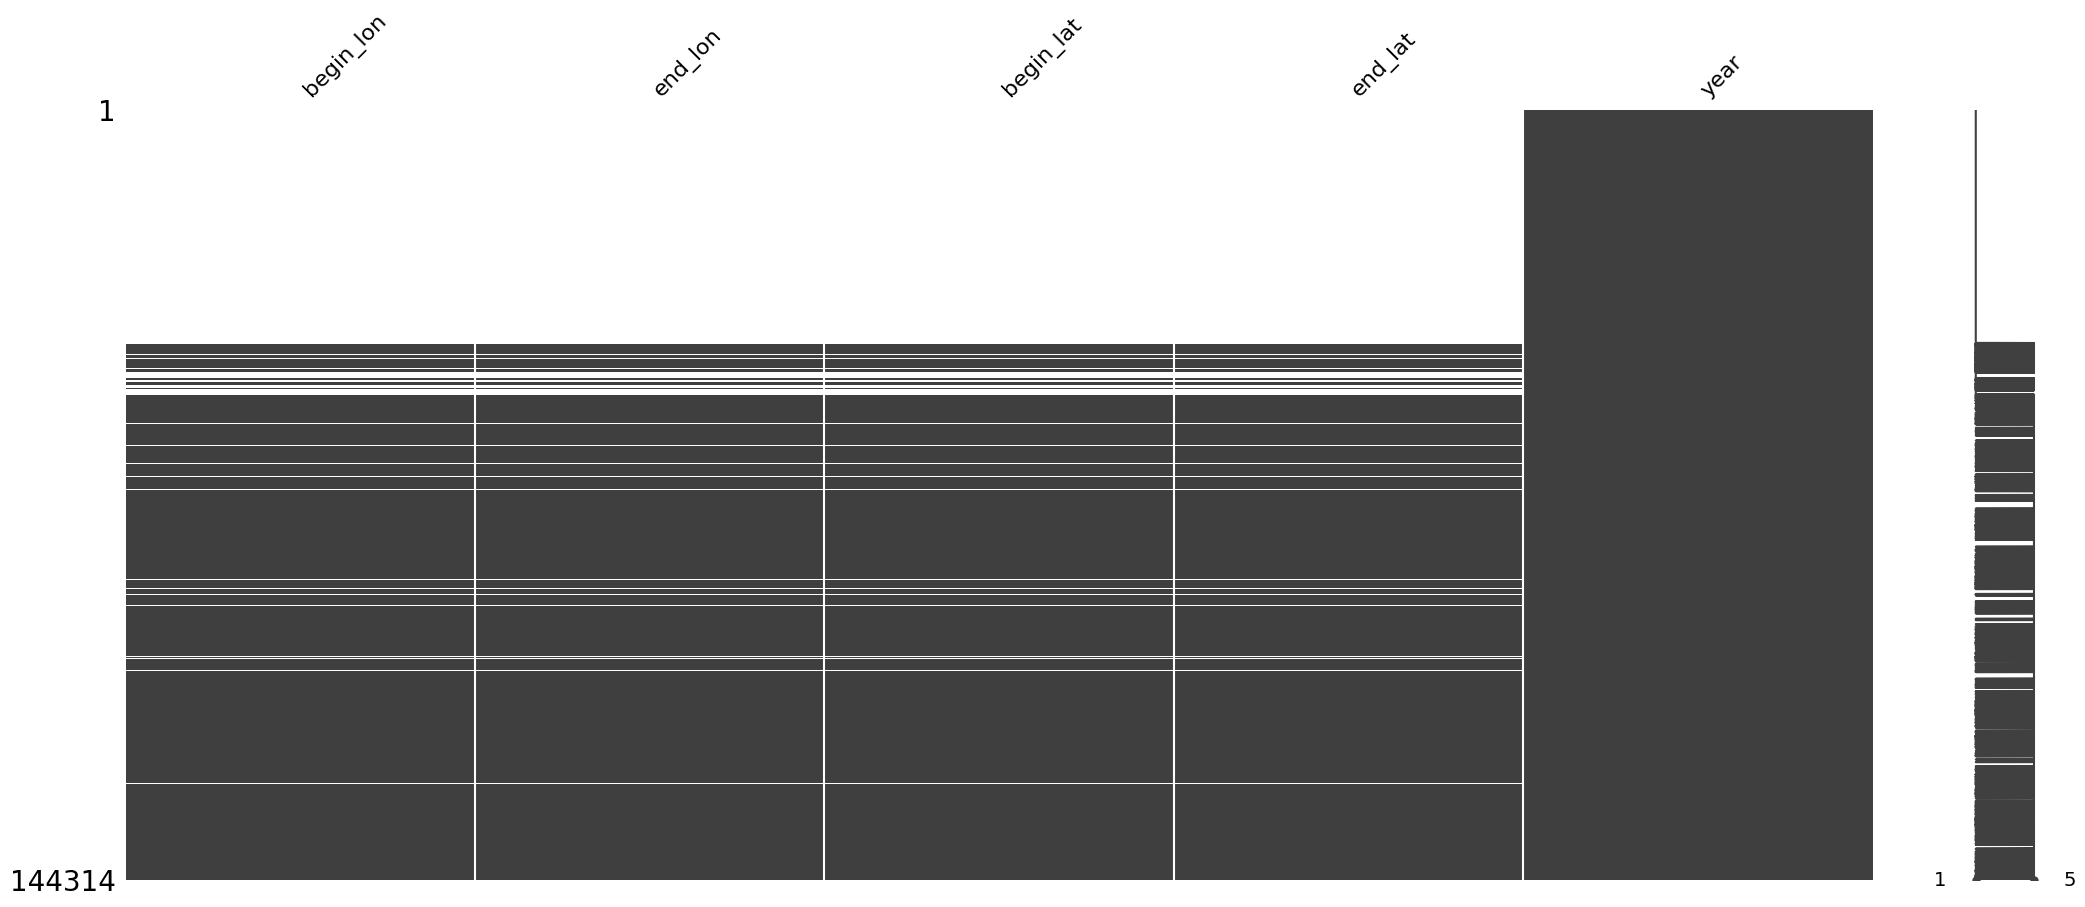

In [15]:
msno.matrix(df_flood[['begin_lon', 'end_lon', 'begin_lat', 'end_lat', 'year']].sort_values('year'))

<Axes: >

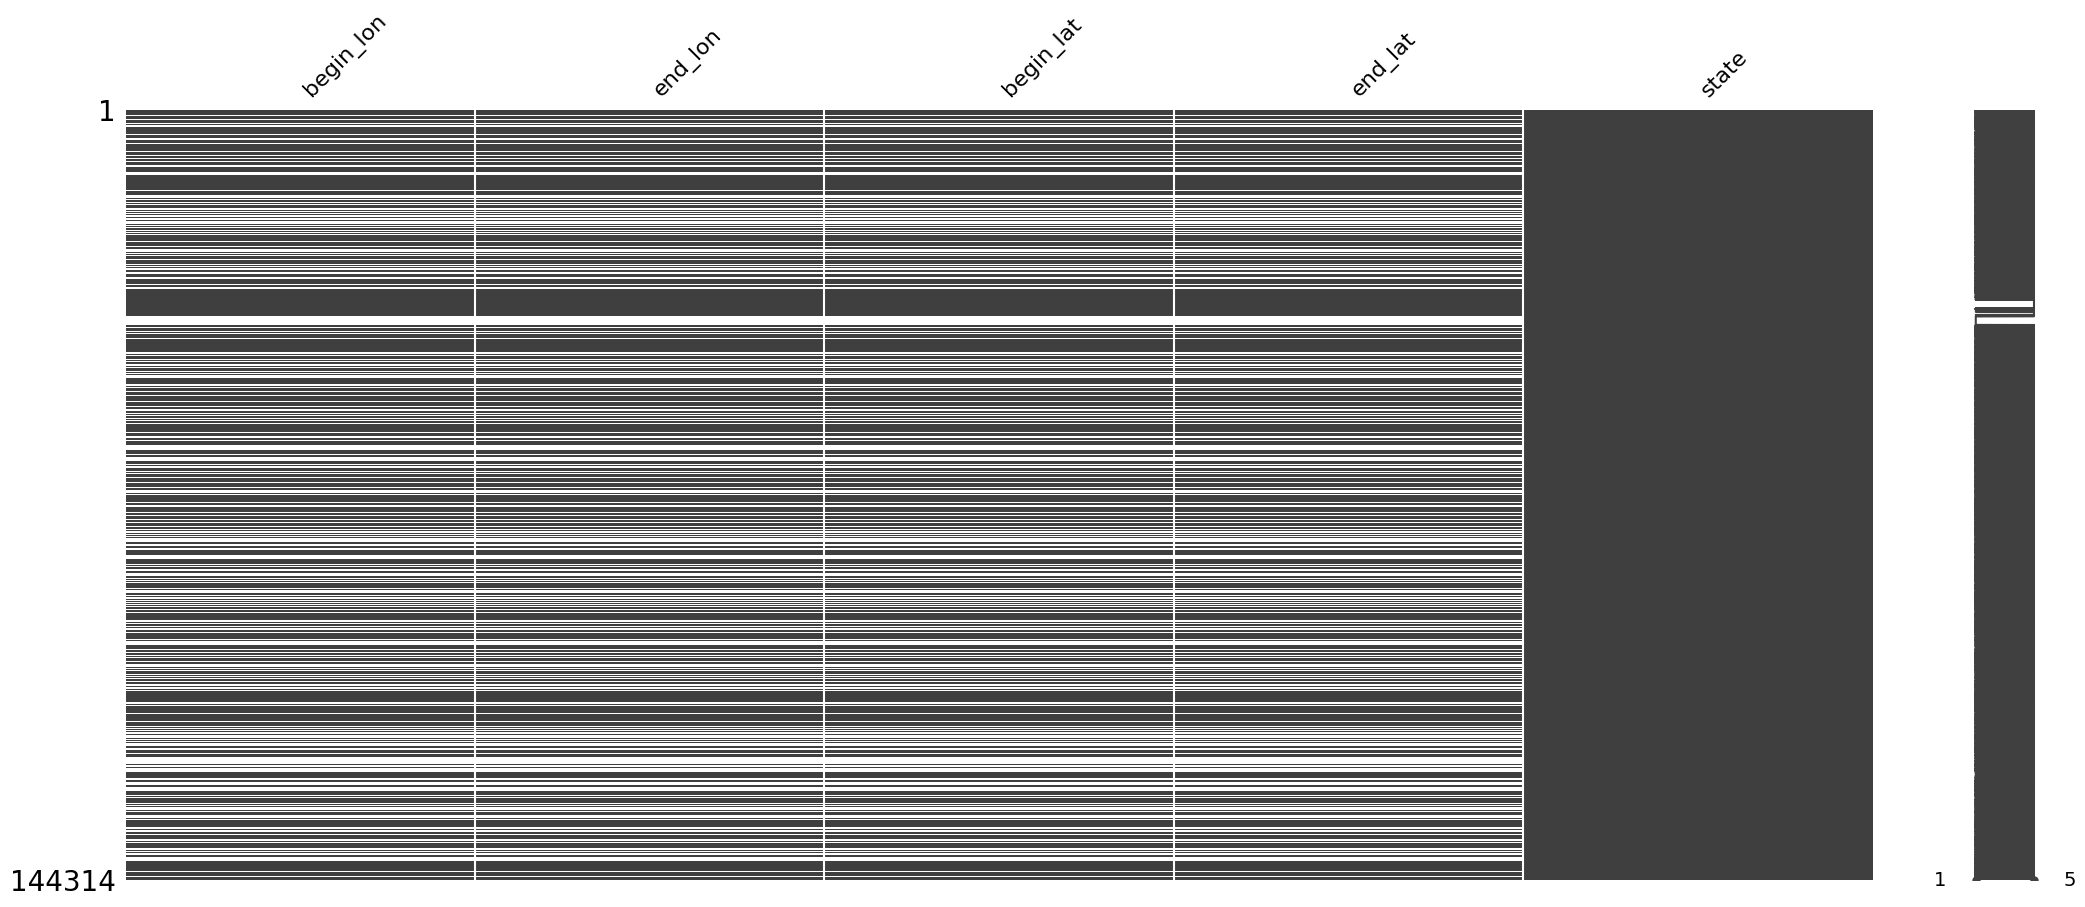

In [16]:
msno.matrix(df_flood[['begin_lon', 'end_lon', 'begin_lat', 'end_lat', 'state']].sort_values('state'))

In [17]:
df_missingloc = df_flood.loc[df_flood[['begin_lon', 'end_lon', 'begin_lat', 'end_lat']].isna().sum(1) == 4, :]
df_missingloc['year'].value_counts().sort_index()  / df_flood.groupby('year').count()['event_id'] * 100

year
1996    100.000000
1997    100.000000
1998    100.000000
2000    100.000000
2001    100.000000
2002    100.000000
2003    100.000000
2004    100.000000
2005     24.919441
2006     66.316047
2007      4.386423
2008      0.954766
2009      3.205742
2010      1.609331
2011      1.839144
2012      7.543466
2013      1.537552
2014      2.133333
2015      3.409091
2016      4.063124
2017      2.927678
2018      3.472149
2019      4.103327
2020      3.824363
dtype: float64

Looks like most missing data is in early years. We'll drop missing for now, but note the percentage of missing lat/long for 2005 and 2006 may make those years less helpful. 

In [18]:
df_flood.dropna(subset=['begin_lon', 'end_lon', 'begin_lat', 'end_lat'], inplace=True)
len(df_flood)

93742

Event types only floods. 

In [19]:
##check that all data is flood data (and not tornado, etc)
df_flood['event_type'].value_counts()

event_type
Flash Flood    55691
Flood          38051
Name: count, dtype: int64

In [20]:
#import 2020 census zip code tabulation areas
zcta = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2020/ZCTA520/tl_2020_us_zcta520.zip')

zcta

,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,35592,35592,B5,G6350,S,298552385,235989,+33.7427261,-088.0973903,"POLYGON ((-88.24735 33.65390, -88.24713 33.654..."
1,35616,35616,B5,G6350,S,559506992,41870756,+34.7395036,-088.0193814,"POLYGON ((-88.13997 34.58184, -88.13995 34.582..."
2,35621,35621,B5,G6350,S,117838488,409438,+34.3350314,-086.7270557,"POLYGON ((-86.81659 34.34960, -86.81649 34.349..."
3,35651,35651,B5,G6350,S,104521045,574316,+34.4609087,-087.4801507,"POLYGON ((-87.53087 34.42492, -87.53082 34.429..."
4,36010,36010,B5,G6350,S,335675180,236811,+31.6598950,-085.8128958,"POLYGON ((-85.95712 31.67744, -85.95676 31.677..."
...,...,...,...,...,...,...,...,...,...,...
33786,10540,10540,B5,G6350,S,1394970,27777,+41.3259819,-073.7277119,"POLYGON ((-73.73580 41.33577, -73.73501 41.335..."
33787,23081,23081,B5,G6350,S,7753698,14654483,+37.1935699,-076.7525080,"POLYGON ((-76.79774 37.21409, -76.79134 37.220..."
33788,23147,23147,B5,G6350,S,143646,0,+37.3696361,-077.0391136,"POLYGON ((-77.04292 37.36996, -77.04143 37.370..."
33789,23298,23298,B5,G6350,S,288664,0,+37.5417074,-077.4295300,"POLYGON ((-77.43285 37.54038, -77.43261 37.540..."


In [21]:
# df_loc = pd.DataFrame([str(x) + ', ' + str(y) for x, y in zip(df_flood['begin_lat'], df_flood['begin_lon'])], columns=['locstr'])
df_loc = pd.DataFrame([Point(str(x),str(y)) for x, y in zip(df_flood['begin_lon'], df_flood['begin_lat'])], columns=['locstr'])

df_loc.index = df_flood['event_id']

gdf_flood = gpd.GeoDataFrame(df_loc, geometry='locstr', crs='EPSG:4269')
gdf_zcta = gpd.sjoin(gdf_flood, zcta, how='left')


Confirmed visual on maps that events with missing zip code were outside the census mapped ZCTA areas and so were removed. 

In [22]:
##merge zip code back to flood data, remove events with missing zip code

df_flood_zip = df_flood.merge(gdf_zcta[['ZCTA5CE20']], how='inner', left_on='event_id', right_index=True)
df_flood_zip = df_flood_zip.dropna(subset='ZCTA5CE20')
df_flood_zip

,begin_yearmonth,begin_day,begin_time,end_yearmonth,end_day,end_time,episode_id,event_id,state,state_fips,...,end_lat,end_lon,episode_narrative,event_narrative,data_source,datetime_begin,datetime_end,fatality,damages,ZCTA5CE20
26,200501,5,2200,200501,8,1100,1183802,5433210,WEST VIRGINIA,54.0,...,39.4700,-78.0200,"By 10 PM on 5th, Rte 40 near Wheeling began to...",NaN,PDS,2005-01-06 03:00:00,2005-01-08 16:00:00,0,5160000.0,25403
44,200502,14,1330,200502,23,2215,1178383,5433069,ILLINOIS,17.0,...,37.2200,-89.3700,Precipitation over Northern Illinois and North...,"Kankakee River, Des Plaines, Upper Illinois an...",PDS,2005-02-14 19:30:00,2005-02-24 04:15:00,0,0.0,62988
77,200501,13,805,200501,13,930,1182733,5433452,MISSISSIPPI,28.0,...,31.6000,-89.2000,NaN,Two to three inches of rain in about an hour a...,PDS,2005-01-13 14:05:00,2005-01-13 15:30:00,0,5000.0,39437
118,200501,5,900,200501,6,1200,1183784,5433115,PENNSYLVANIA,42.0,...,41.2200,-79.4300,"By 9 AM on 5th, numerous streams were out of t...",NaN,PDS,2005-01-05 14:00:00,2005-01-06 17:00:00,0,15000.0,16254
119,200501,11,2300,200501,12,500,1183785,5433116,PENNSYLVANIA,42.0,...,41.2200,-79.4300,"By 11 PM, 3 roads were flooded near Brave. Nin...",NaN,PDS,2005-01-12 04:00:00,2005-01-12 10:00:00,0,0.0,16254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39924,202006,11,1431,202006,11,1501,148971,897760,CONNECTICUT,9.0,...,41.4133,-73.4700,Showers and thunderstorms developed out ahead ...,Clapboard Ridge Road was closed due to floodin...,CSV,2020-06-11 18:31:00,2020-06-11 19:01:00,0,0.0,06811
39998,202006,7,1415,202006,7,2346,148220,894216,FLORIDA,12.0,...,30.3486,-83.1190,Deep tropical moisture was in place (PWAT 2.5)...,"At 2:15 pm, flood water was starting to impact...",CSV,2020-06-07 18:15:00,2020-06-08 03:46:00,0,0.0,32060
40034,202006,22,2320,202006,24,915,148769,899497,IOWA,19.0,...,42.2003,-92.4637,A surface low to the northwest of Iowa allowed...,The department of transportation relayed a rep...,CSV,2020-06-23 04:20:00,2020-06-24 14:15:00,0,0.0,50675
40035,202006,23,38,202006,24,915,148769,899498,IOWA,19.0,...,42.2001,-92.4647,A surface low to the northwest of Iowa allowed...,Iowa Department of Transportation and the Tama...,CSV,2020-06-23 05:38:00,2020-06-24 14:15:00,0,0.0,50675


Next steps download and look at Census data

In [9]:
##load census API Key

load_dotenv()
API_KEY = os.getenv('census_api_key')


In [135]:
fields_dict = {'NAME': 'Name',
               'B19081_001E': 'houseinc_1',
               'B19081_002E': 'houseinc_2',
               'B19081_003E': 'houseinc_3',
               'B19081_004E': 'houseinc_4',
               'B19081_005E': 'houseinc_5',
               'B19081_006E': 'houseinc_top5',
               'B19013_001E': 'med_houseinc_12mon',
               'B19058_001E': 'household_public_assistance1'
              }

fields = ','.join(list(fields_dict.keys()))
names = list(fields_dict.values()) + ['ztca']


['Name',
 'houseinc_1',
 'houseinc_2',
 'houseinc_3',
 'houseinc_4',
 'houseinc_5',
 'houseinc_top5',
 'med_houseinc_12mon',
 'household_public_assistance1',
 'household_public_assistance2',
 'ztca']

In [139]:


url = 'https://api.census.gov/data/2022/acs/acs5?get=' + fields + '&for=zip%20code%20tabulation%20area:*&key=' + API_KEY

r_test = requests.get(url)
r_test
# print(len(r_test.json()))
r_test.json()
df_census = pd.DataFrame(r_test.json()[1::], columns=names)
df_census.head()

,Name,houseinc_1,houseinc_2,houseinc_3,houseinc_4,houseinc_5,houseinc_top5,med_houseinc_12mon,household_public_assistance1,household_public_assistance2,ztca
0,ZCTA5 00601,3852,10764,17479,26997,56362,96549,17526,5341,3174,00601
1,ZCTA5 00602,4160,12496,20599,33220,73001,118717,20260,12777,7312,00602
2,ZCTA5 00603,1427,9622,18169,34313,88526,154617,17703,19624,10545,00603
3,ZCTA5 00606,2967,10850,19373,30163,55892,78806,19603,1948,1152,00606
4,ZCTA5 00610,5104,13917,23066,35958,78734,129039,22796,8781,4903,00610


In [140]:
df_census.isna().sum()

Name                               0
houseinc_1                      8072
houseinc_2                      8072
houseinc_3                      8072
houseinc_4                      8072
houseinc_5                      8072
houseinc_top5                   8072
med_houseinc_12mon                 0
household_public_assistance1       0
household_public_assistance2       0
ztca                               0
dtype: int64

In [54]:
va_census = c.acs5.state_zipcode(fields = ('NAME', 'B09010_001E', 'GEO_ID'),
                                      state_fips = '44',
                                      zcta = '*', year=2021)
pd.DataFrame(va_census)

,NAME,B09010_001E,GEO_ID,zip code tabulation area
0,ZCTA5 00601,3187.0,860Z200US00601,00601
1,ZCTA5 00602,6446.0,860Z200US00602,00602
2,ZCTA5 00603,8702.0,860Z200US00603,00603
3,ZCTA5 00606,1001.0,860Z200US00606,00606
4,ZCTA5 00610,4491.0,860Z200US00610,00610
...,...,...,...,...
33769,ZCTA5 99923,0.0,860Z200US99923,99923
33770,ZCTA5 99925,202.0,860Z200US99925,99925
33771,ZCTA5 99926,357.0,860Z200US99926,99926
33772,ZCTA5 99927,0.0,860Z200US99927,99927


In [52]:
pd.DataFrame(va_census)['STATE'].unique()

array([None], dtype=object)

In [66]:
c.acs5.tables()

[{'name': 'B17015',
  'description': 'POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILIES BY FAMILY TYPE BY SOCIAL SECURITY INCOME BY SUPPLEMENTAL SECURITY INCOME (SSI) AND CASH PUBLIC ASSISTANCE INCOME',
  'variables': 'http://api.census.gov/data/2021/acs/acs5/groups/B17015.json',
  'universe ': 'Families'},
 {'name': 'B18104',
  'description': 'SEX BY AGE BY COGNITIVE DIFFICULTY',
  'variables': 'http://api.census.gov/data/2021/acs/acs5/groups/B18104.json',
  'universe ': 'Civilian noninstitutionalized population 5 years and over'},
 {'name': 'B17016',
  'description': 'POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILIES BY FAMILY TYPE BY WORK EXPERIENCE OF HOUSEHOLDER AND SPOUSE',
  'variables': 'http://api.census.gov/data/2021/acs/acs5/groups/B17016.json',
  'universe ': 'Families'},
 {'name': 'B18105',
  'description': 'SEX BY AGE BY AMBULATORY DIFFICULTY',
  'variables': 'http://api.census.gov/data/2021/acs/acs5/groups/B18105.json',
  'universe ': 'Civilian noninstitutionalized populat